In [1]:
!pip install -U git+https://github.com/huggingface/transformers@v4.49.0-Gemma-3
!pip install -U accelerate bitsandbytes

  Cloning https://github.com/huggingface/transformers (to revision v4.49.0-Gemma-3) to /tmp/pip-req-build-eoi4n5ia
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-eoi4n5ia
  Running command git checkout -q 1c0f782fe5f983727ff245c4c1b3906f9b99eec2
  Resolved https://github.com/huggingface/transformers to commit 1c0f782fe5f983727ff245c4c1b3906f9b99eec2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


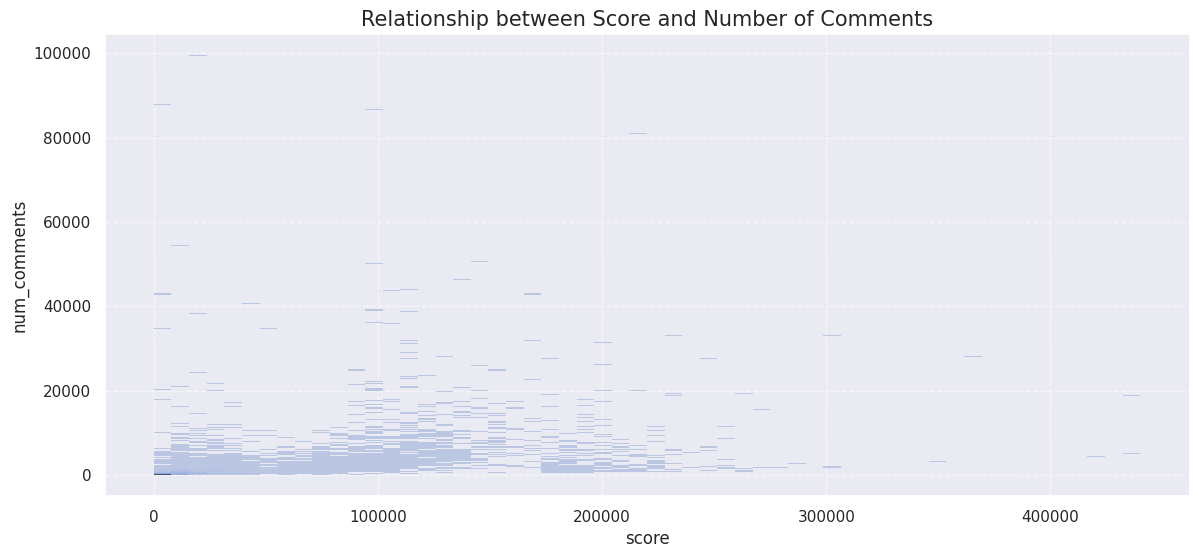

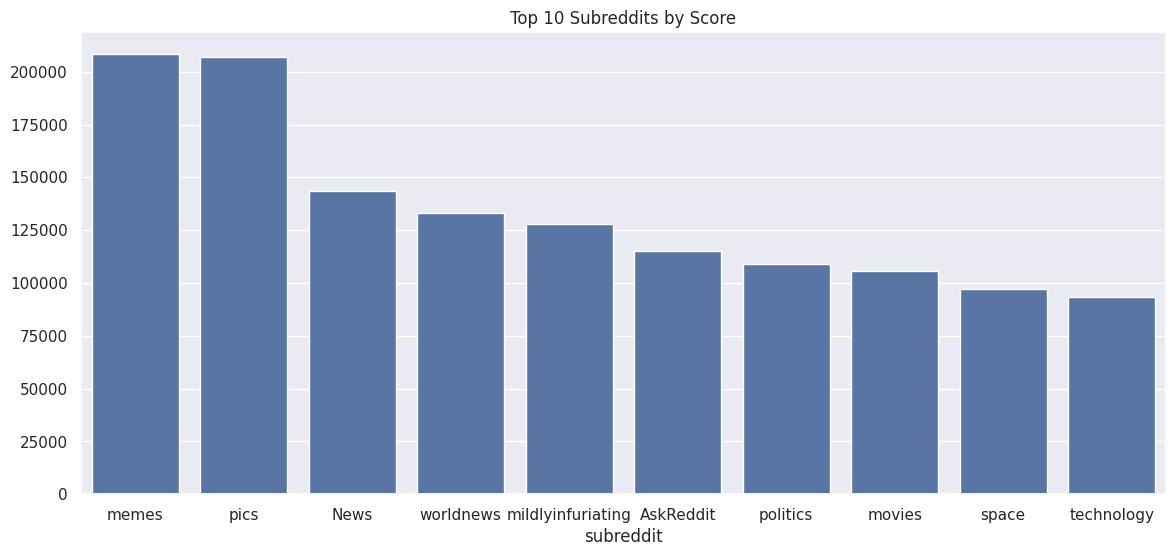

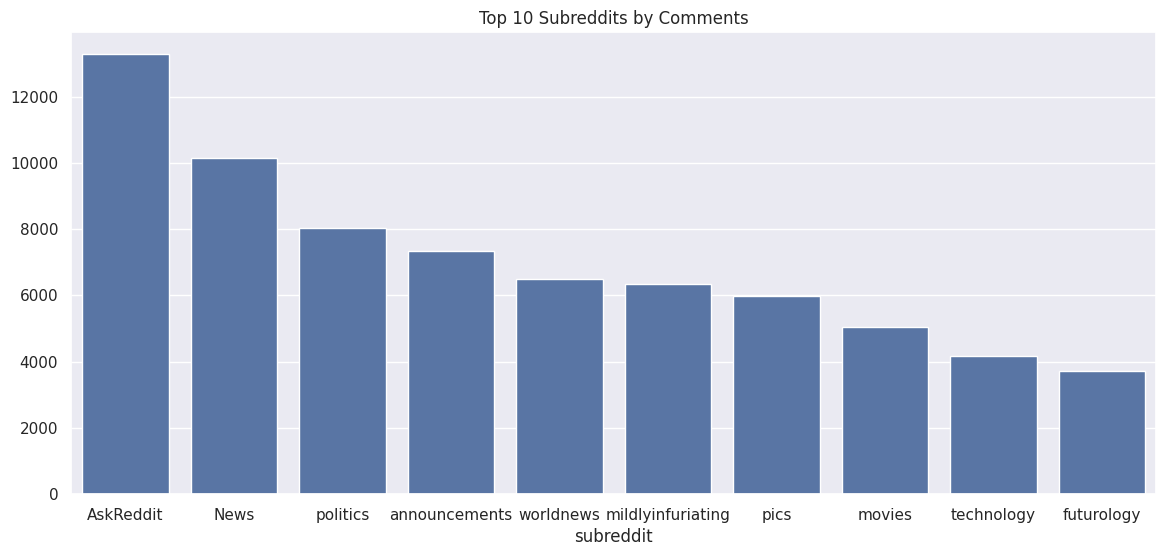

In [87]:
#EDA

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('/kaggle/input/dataset/Merged_data.csv')
# print(df.info())
# print(df.isnull().sum())


# sns.set_theme(style="darkgrid")
# fig, ax = plt.subplots(figsize=(16, 8), dpi=100)

plt.figure(figsize=(14, 6))
sns.histplot(data=df, x='score', y='num_comments',legend=False)

plt.title('Relationship between Score and Number of Comments', fontsize=15)
plt.grid(True, linestyle='--', alpha=0.6)

popularity_by_comments = df.groupby('subreddit')['num_comments'].mean().nlargest(10)
popularity_by_score = df.groupby('subreddit')['score'].mean().nlargest(10)
plt.figure(figsize=(14, 6))
sns.barplot(x=popularity_by_score.index, y=popularity_by_score.values)
plt.title("Top 10 Subreddits by Score")

plt.figure(figsize=(14, 6))
sns.barplot(x=popularity_by_comments.index, y=popularity_by_comments.values)
plt.title("Top 10 Subreddits by Comments")
plt.show()


In [29]:
#dataset insfo
df = pd.read_csv('/kaggle/input/dataset/Merged_data.csv')
df_images = df[df['image_url'].notna()]
# We take a random sample of 50
df_sample = df_images.sample(n=50, random_state=42)

# 2. Select only the columns required
df_sample = df_sample[['image_url', 'title']]
df_sample = df_images.sample(n=50, random_state=42).reset_index(drop=True)
# print(df_sample.iloc[1][1])
sample_title = df_sample.at[4, 'title']
sample_url = df_sample.at[4, 'image_url']

print(f"Title: {title}")
print(f"URL: {url}")

Title: Lahori Zeera, started by 3 brothers in 2017, has grown into a ₹530 CR desi thanda giant
URL: https://i.redd.it/tk44cdbxkhsf1.jpeg


In [68]:
# df.info
print(df.head())

  subreddit                                          permalink  score  \
0  Medicine  https://old.reddit.com/r/medicine/comments/qzu...   8052   
1  Medicine  https://old.reddit.com/r/medicine/comments/fp2...   4956   
2  Medicine  https://old.reddit.com/r/medicine/comments/kb3...   4808   
3  Medicine  https://old.reddit.com/r/medicine/comments/rqx...   4614   
4  Medicine  https://old.reddit.com/r/medicine/comments/fnz...   4421   

   num_comments                                              title  \
0           599  A detailed description of how you die from COV...   
1           356               3 Days of Inpatient Care in New York   
2           132  Help! A doctor in my hometown was kidnapped by...   
3           405                                   Powerless [Rant]   
4           335  Dr. Usama Riaz has spent weeks screening, trea...   

                                           body_text image_url  
0  Good morning.\nI squeeze your hand.\n“It’s Fri...       NaN  
1         

In [30]:
# huggingface login
from huggingface_hub import login

from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
hf_token=user_secrets.get_secret("HF_Token")
login(token=hf_token)

In [32]:
#Extracting embeddings from CLIP

from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import requests

# Load model and processor
model_id = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)

# Prepare inputs
url = str(sample_url)
image = Image.open(requests.get(url, stream=True).raw)
text = [str(sample_title), "a photo of a dog"]

inputs = processor(text=text, images=image, return_tensors="pt", padding=True)

# Generate Embeddings
outputs = model(**inputs)

image_embeds = model.get_image_features(pixel_values=inputs['pixel_values'])
text_embeds = model.get_text_features(input_ids=inputs['input_ids'])


In [35]:
# calculating similarity scores

import torch.nn.functional as F

# Assuming 'image_embeds' and 'text_embeds' are your outputs from earlier
# Normalize first (crucial for CLIP)
img_norm = F.normalize(image_embeds, p=2, dim=-1)
txt_norm = F.normalize(text_embeds, p=2, dim=-1)

# Calculate similarity (ranging from -1 to 1)
similarity = (img_norm @ txt_norm.T) 
# This will print [score1, score2]
print(f"Similarity Scores: {similarity.detach().cpu().numpy()}")

Similarity Scores: [[0.32102415 0.13171239]]
